Load the liabrary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

Load data

In [2]:
df = pd.read_csv("../data/laptop_final.csv")
print(df.head(5))
print(df.columns)

                                                link  \
0  https://laptopmedia.com/laptop-specs/asus-rog-...   
1  https://laptopmedia.com/laptop-specs/asus-rog-...   
2  https://laptopmedia.com/laptop-specs/asus-rog-...   
3  https://laptopmedia.com/laptop-specs/asus-rog-...   
4  https://laptopmedia.com/laptop-specs/asus-rog-...   

                       name  Display Size  Resolution: width  \
0        ASUS ROG Strix G17          17.3             2560.0   
1  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
2  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
3  ASUS ROG Zephyrus Duo 16          16.0             2560.0   
4        ASUS ROG Strix G17          17.3             2560.0   

   Resolution: height  Refresh Rate       Panel Type  Disk Capacity  SSD  HDD  \
0              1440.0         240.0     IPS + G-Sync         2000.0  1.0  0.0   
1              1600.0         240.0   IPS + FreeSync        16000.0  1.0  0.0   
2              1600.0         240.0

In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df=df.drop(columns=["link","name","Total Score","Work Score","Display Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df = df.drop_duplicates()

Drop nan values

In [4]:
df.isnull().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 256
RAM Type                                   26332
OS                                           659
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [5]:
df2 = df.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is: {} and after drop nan values is: {}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is: 148426 and after drop nan values is: 77987


Add more features following our knowledge about laptop architecture

In [6]:
# Add the connectivity score that is the sum of connection gate availability in laptop
df2['Connectivity Score'] = df2[['USB Type-C', 'USB Type-A', 'HDMI', 'Card Reader']].sum(axis=1)

# Add the Lightweight Build for specific low-weighted materials.
lightweight_materials = ['Body material: magnesium alloy', 'Body material: carbon', 'Body material: plastic']
threshold_weight = 2.0
df2['Lightweight Build'] = df2.apply(lambda x: 1 if any(mat in x for mat in lightweight_materials) and x['Weight'] < threshold_weight else 0, axis=1)
print(df2['Lightweight Build'].value_counts())

# Add the Portability feature count as sum of the convinience of laptop
df2['Portability Feature Count'] = df2[['Fingerprint reader', 'Backlit keyboard', 'Security Lock slot']].sum(axis=1)


C:\Users\Acer\AppData\Local\Temp\ipykernel_22900\886753244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Connectivity Score'] = df2[['USB Type-C', 'USB Type-A', 'HDMI', 'Card Reader']].sum(axis=1)


Lightweight Build
0    39188
1    38799
Name: count, dtype: int64


C:\Users\Acer\AppData\Local\Temp\ipykernel_22900\886753244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Lightweight Build'] = df2.apply(lambda x: 1 if any(mat in x for mat in lightweight_materials) and x['Weight'] < threshold_weight else 0, axis=1)
C:\Users\Acer\AppData\Local\Temp\ipykernel_22900\886753244.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Portability Feature Count'] = df2[['Fingerprint reader', 'Backlit keyboard', 'Security Lock slot']].sum(axis=1)


Divide into train test split before encoding to prevent overfiting

In [7]:
target="Portability Score"
X=df2.drop(columns=[target])
y=df2[target]

In [8]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

Encode categorical columns using target encoding

In [9]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df2[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [10]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
# Transform this encoder in X_test
X_test=encoder.transform(X_test)

Features Selection

In [11]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]
categorical_features=list(set(df2.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Body material: magnesium alloy', 'Body material: black synthetic material', 'Body material: aluminum', 'SSHD', 'Body material: magnesium-lithium alloy', 'Fingerprint reader', 'Lightweight Build', 'Portability Feature Count', 'Connectivity Score', 'Body material: plastic', 'Optane', 'OS', 'Body material: matte', 'Security Lock slot', 'GPU: Architecture', 'Body material: carbon', 'HDD', 'Card Reader', 'Body material: glass fiber', 'RAM Type', 'Panel Type', 'Backlit keyboard', 'SSD', 'GPU: Memory Type', 'Body material: plastic / polycarbonate']
25


In [12]:
# Normalization for features selection.
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train.head(5)

,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,SSHD,Optane,...,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption,Connectivity Score,Lightweight Build,Portability Feature Count
25443,0.256793,1.097297,1.409002,0.878616,6.690194,0.000980,1.0,0.0,0.0,0.0,...,5.893713,2.459488,3.270461,0.296986,1.821572,1.206739,2.191542,7.1,1,3.0
66496,0.256793,-0.313549,0.037011,-0.679787,6.690194,-0.380632,1.0,0.0,0.0,0.0,...,7.437377,-0.530649,-0.884368,2.243079,-0.958845,1.206739,-0.193418,6.0,1,2.0
145755,-0.109668,-0.313549,-0.374586,0.566935,6.690194,-0.380632,1.0,0.0,0.0,0.0,...,5.893713,-0.210277,0.154339,0.765947,0.431363,0.415036,0.325051,5.0,0,1.0
42948,-0.109668,-0.313549,-0.374586,0.566935,6.118876,0.000980,1.0,0.0,0.0,0.0,...,5.893713,-0.210277,1.193047,-0.585875,1.821572,1.206739,0.947215,6.0,0,2.0
56103,-1.575513,-0.313549,-0.374586,0.566935,6.118876,0.000980,1.0,0.0,0.0,0.0,...,5.893713,-0.156882,0.673693,0.154589,1.126468,0.151135,0.428745,6.0,1,3.0


Using mutual info and anova to find the most relevant categorical features

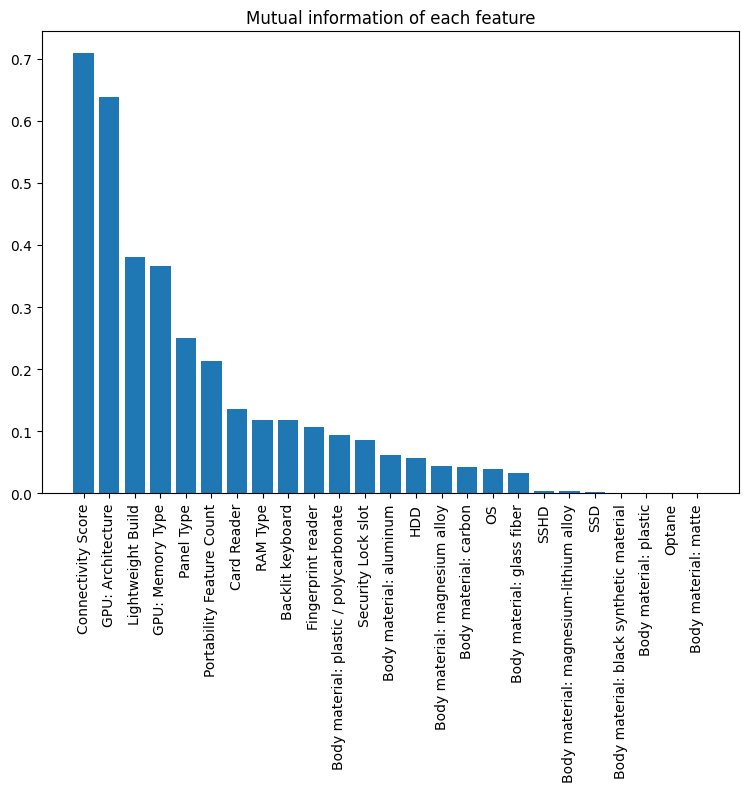

In [13]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 1  9 12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


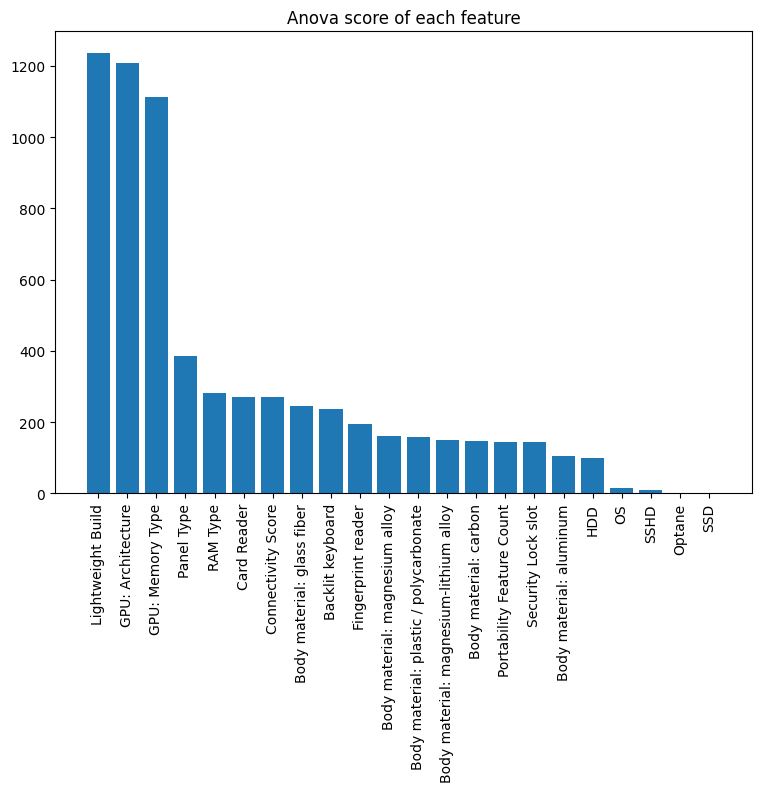

In [14]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

Using pearson, spearman correlation to find the most relevant in numerical features

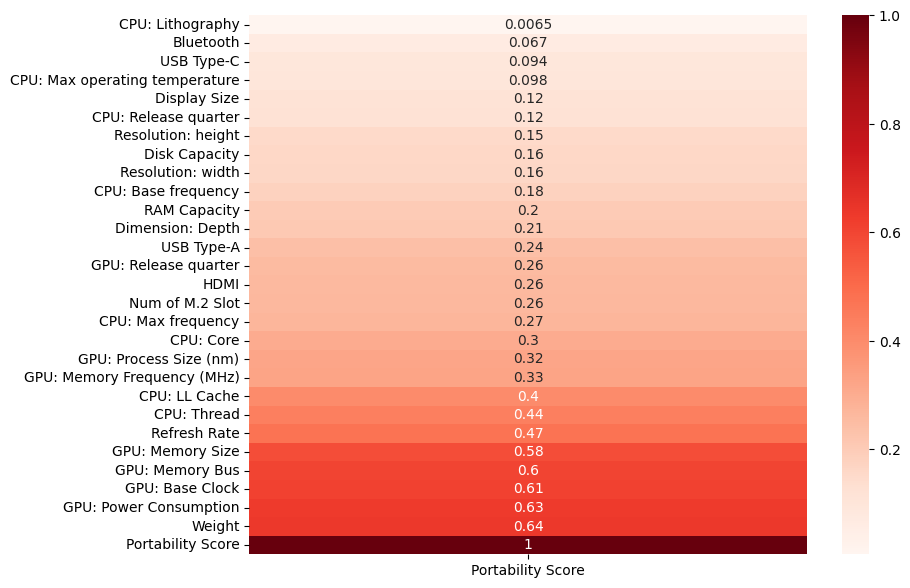

In [15]:
# using pearson score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

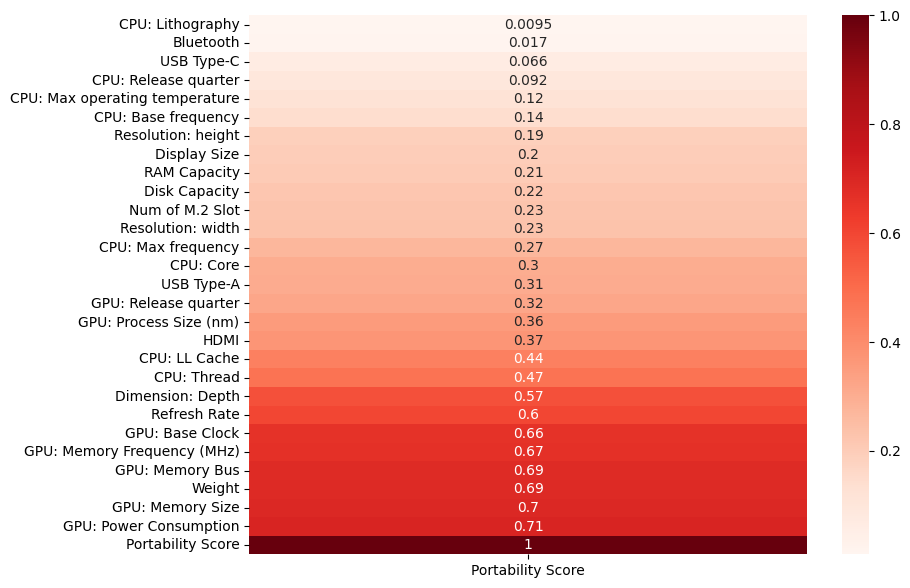

In [16]:
# using spearman score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

Using Random Forest to choose important features in 2 groups

In [17]:
# Choose candidate features in 2 groups
candidate_num_features = target_correlation[target].abs().sort_values(ascending=False).index[1:6].tolist()
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['Connectivity Score', 'GPU: Architecture', 'Lightweight Build', 'GPU: Memory Type', 'Panel Type', 'GPU: Power Consumption', 'GPU: Memory Size', 'Weight', 'GPU: Memory Bus', 'GPU: Memory Frequency (MHz)']


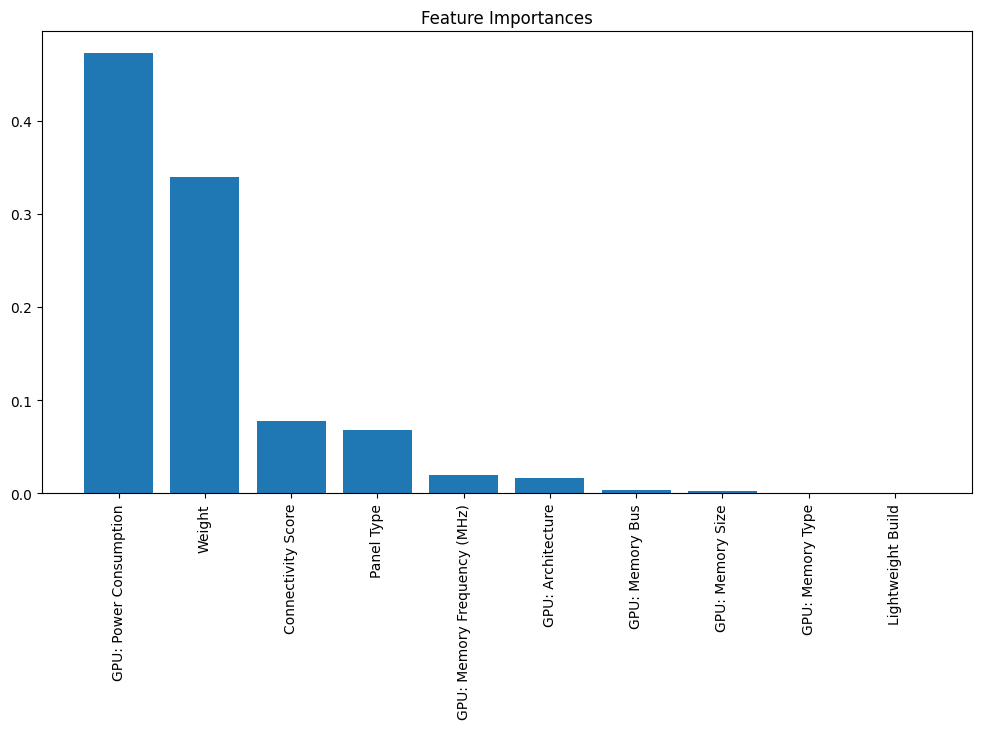

In [18]:
candidate_X = X_train[candidate_featues]
model = RandomForestRegressor()
model.fit(candidate_X, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [19]:
choosen_features = ["GPU: Power Consumption", "Weight", "Connectivity Score", "Panel Type","GPU: Memory Frequency (MHz)","GPU: Architecture"]

Outlier Detection 

In [30]:
choosen_cat_features = ["Connectivity Score","Panel Type"]
choosen_num_features = ["GPU: Power Consumption", "Weight", "GPU: Memory Frequency (MHz)","GPU: Architecture"]
print(choosen_cat_features)
print(choosen_num_features)

['Connectivity Score', 'Panel Type']
['GPU: Power Consumption', 'Weight', 'GPU: Memory Frequency (MHz)', 'GPU: Architecture']


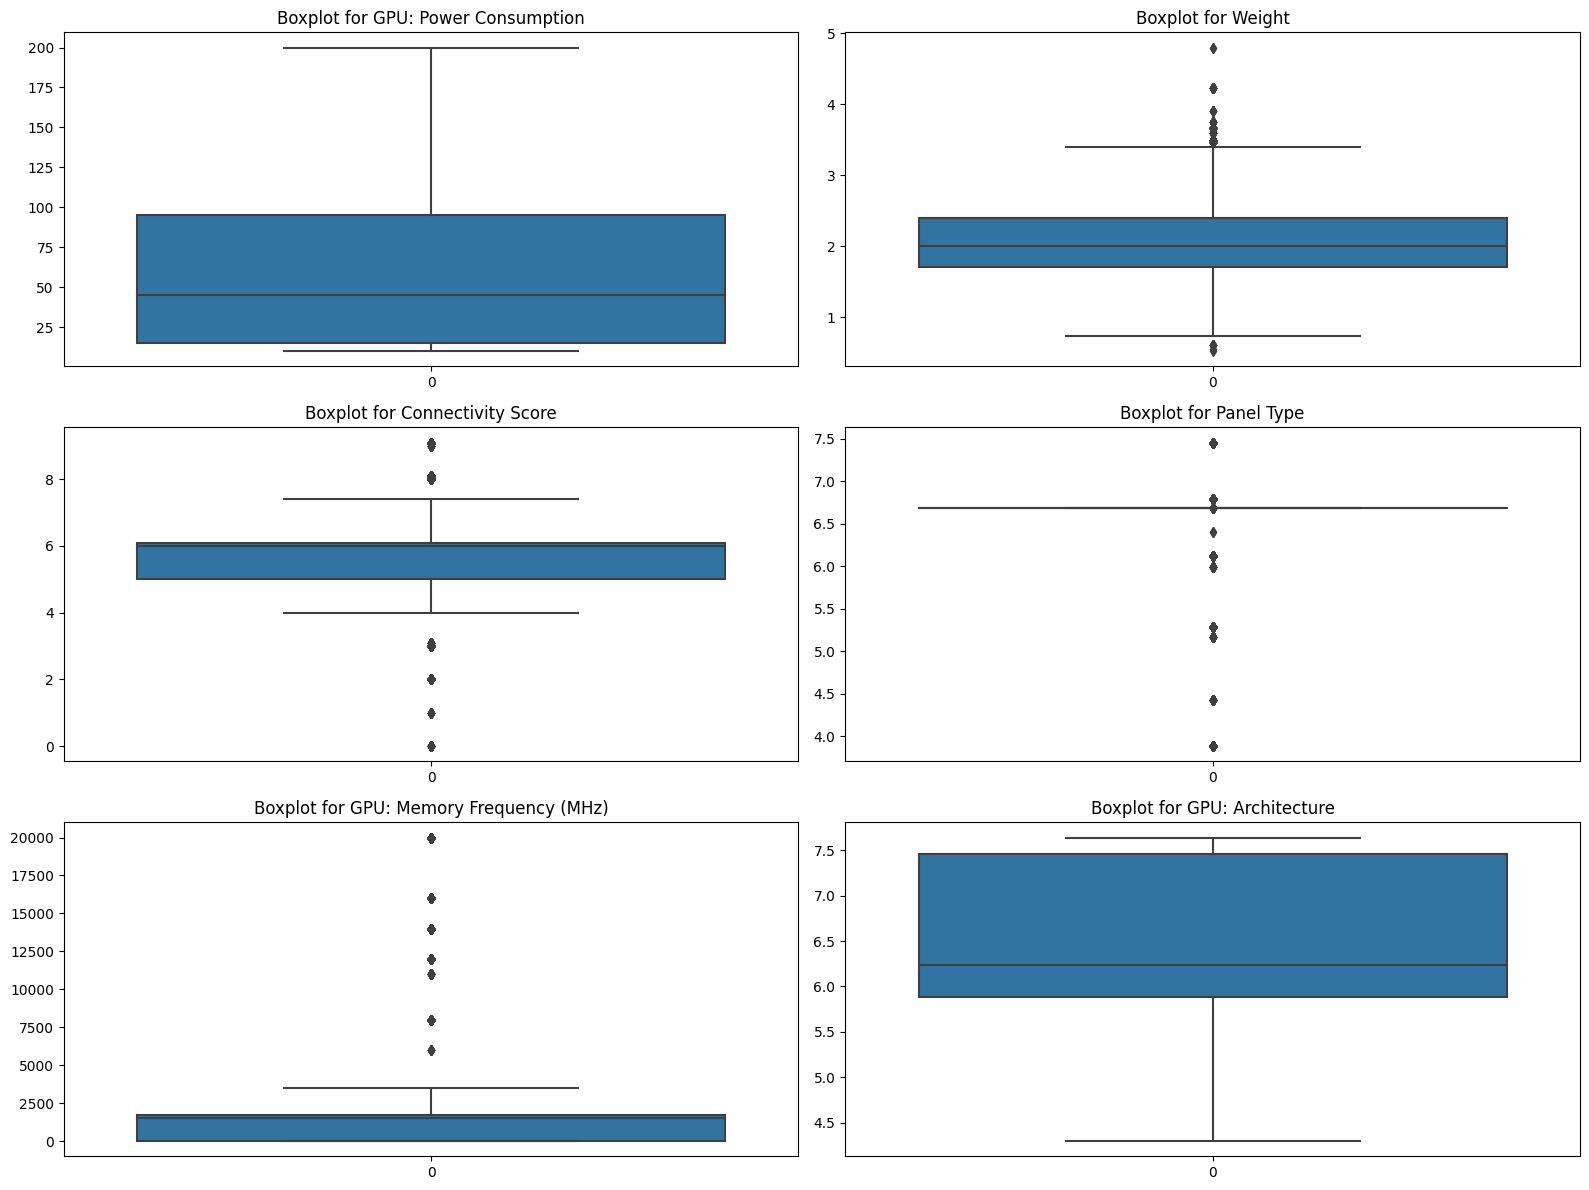

In [47]:
plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.boxplot(X_train[var])
  plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

Numerical features

For numerical features in choosen important features, we will use IQR(Interquartile Range) or MAD(Median Absolute Deviation) for common and easy use. Particularly, IQR would be proposed to be used for symmetric features, whereas, MAD is for heavily skewed features

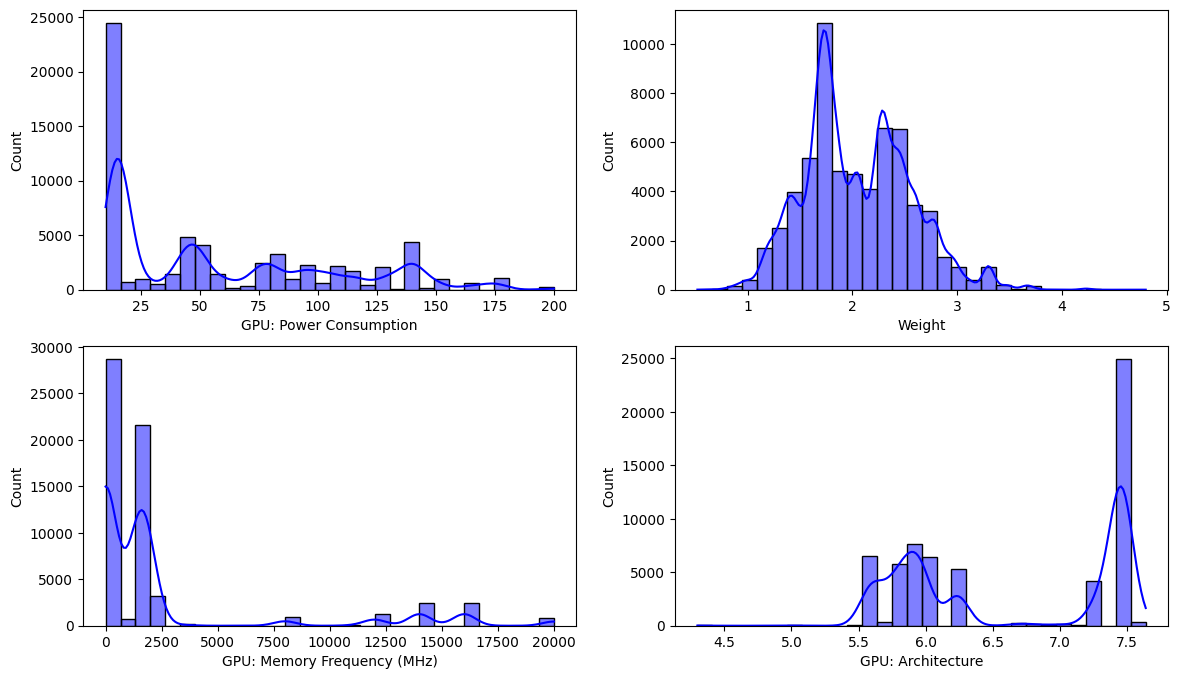

In [87]:
# drawing the distribution of all choosen_num_features
n_features = len(choosen_num_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten() 
for idx, feature in enumerate(choosen_num_features):
    ax = axes[idx]
    sns.histplot(X_train[feature], kde=True, bins=30, color='blue', ax=ax)

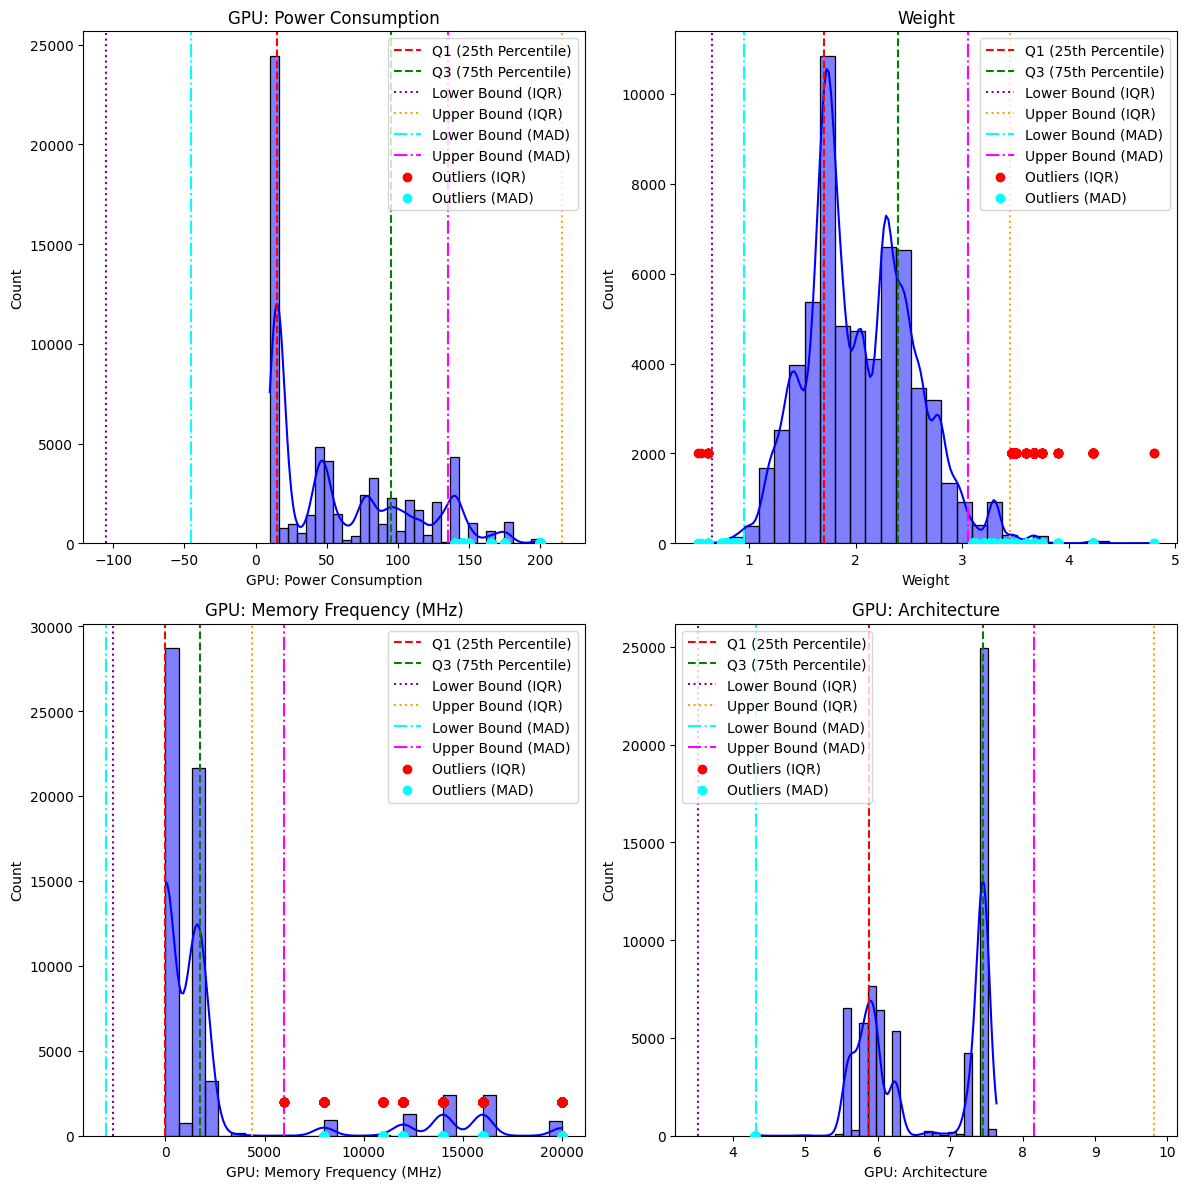

In [41]:
# Suppose the removal of outlier based on IQR and MAD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=30, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
n_features = len(choosen_num_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()  
for i in range(n_features):
    plot_distribution(X_train[choosen_num_features[i]], axes[i], choosen_num_features[i])
plt.tight_layout()
plt.show()


In [46]:
for feat in choosen_num_features:
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[feat])
    outliers_iqr = X_train[(X_train[feat] < lower_bound_iqr) | (X_train[feat]> upper_bound_iqr)]
    print("Number of outlier based on IQR technique in feature "+ feat+": "+"{}".format(len(outliers_iqr)))
    outliers_mad = X_train[(X_train[feat] < lower_bound_mad) | (X_train[feat]> upper_bound_mad)]
    print("Number of outlier based on MAD technique in feature "+ feat+": "+"{}".format(len(outliers_mad)))

Number of outlier based on IQR technique in feature GPU: Power Consumption: 0
Number of outlier based on MAD technique in feature GPU: Power Consumption: 7431
Number of outlier based on IQR technique in feature Weight: 421
Number of outlier based on MAD technique in feature Weight: 1924
Number of outlier based on IQR technique in feature GPU: Memory Frequency (MHz): 7926
Number of outlier based on MAD technique in feature GPU: Memory Frequency (MHz): 7917
Number of outlier based on IQR technique in feature GPU: Architecture: 0
Number of outlier based on MAD technique in feature GPU: Architecture: 32


In [49]:
#Removal of outliers in weight using IQR technique and GPU Architecture using MAD technique.
Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train["Weight"])
print("Original X_train shape:", X_train.shape[0])

reduced_X_train = X_train[(X_train["Weight"] >= lower_bound_iqr) & (X_train["Weight"] <= upper_bound_iqr)]
reduced_y_train = y_train[reduced_X_train.index]
print("X_train shape after removal of Weight outlier :", reduced_X_train.shape[0])
print("Reduced y_train shape after removal of Weight outlier:", reduced_y_train.shape[0])


Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train["GPU: Architecture"])
reduced2_X_train = reduced_X_train[(reduced_X_train["GPU: Architecture"] >= lower_bound_mad) & (reduced_X_train["GPU: Architecture"] <= upper_bound_mad)]
reduced2_y_train = reduced_y_train[reduced2_X_train.index]
print("X_train shape after removal of GPU: Architecture outlier :", reduced2_X_train.shape[0])
print("Reduced y_train shape after removal of GPU: Architecture outlier:", reduced2_y_train.shape[0])



Original X_train shape: 62389
X_train shape after removal of Weight outlier : 61968
Reduced y_train shape after removal of Weight outlier: 61968
X_train shape after removal of GPU: Architecture outlier : 61936
Reduced y_train shape after removal of GPU: Architecture outlier: 61936


Categorical features

In [66]:
threshold_percentage = 1 # put threshold percentage of 1 %
for feat in choosen_cat_features:
    freq = reduced2_X_train[feat].value_counts(normalize=True) * 100  
    rare_categories = freq[freq < threshold_percentage].index.tolist()
    num_outlier = X_train[feat].isin(rare_categories).sum()
    print(feat + ": "+ str(num_outlier))
    reduced2_X_train = reduced2_X_train[~reduced2_X_train[feat].isin(rare_categories)]
    reduced2_y_train = reduced2_y_train[reduced2_X_train.index] 


Connectivity Score: 1385
Panel Type: 401


In [68]:
print(reduced2_X_train.shape[0])
print(reduced2_y_train.shape[0])

60323
60323


Plot the relationship between the features and the target

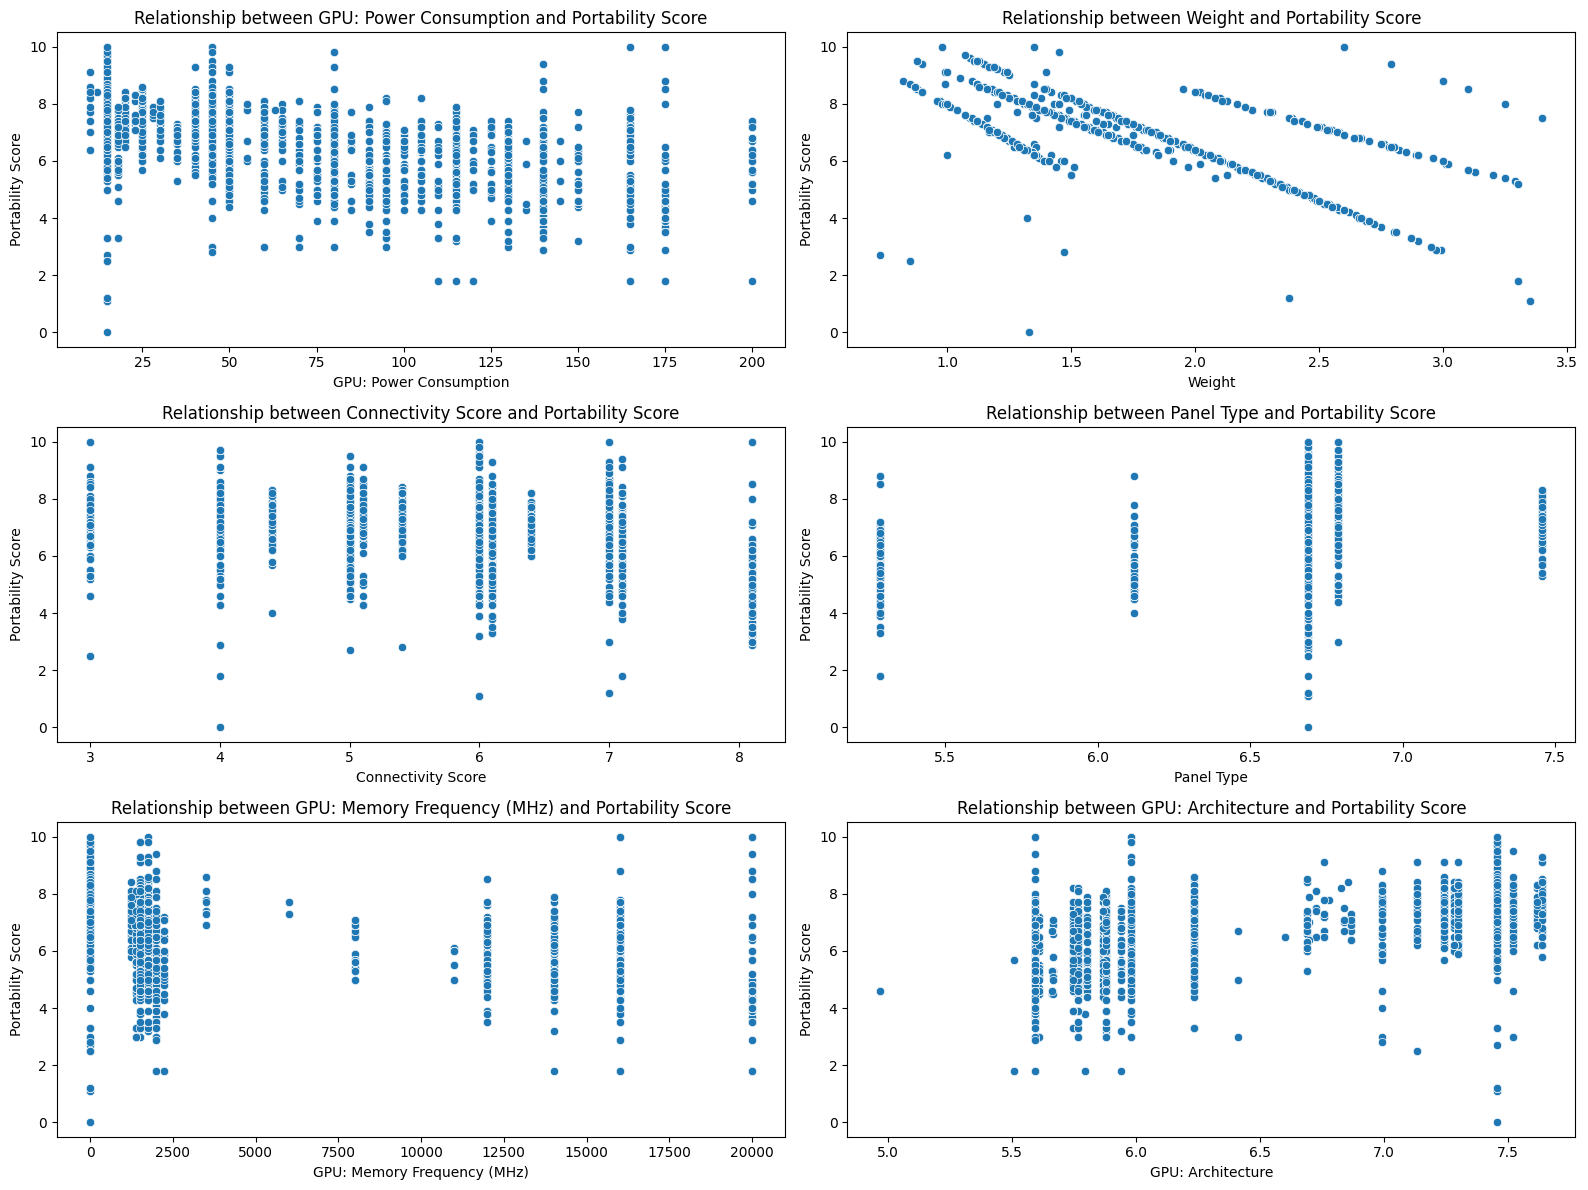

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
for i,var in enumerate(choosen_features):
  plt.subplot(3,2,i+1)
  sns.scatterplot(x=reduced2_X_train[var], y=reduced2_y_train)
  plt.title(f'Relationship between {var} and Portability Score')
plt.tight_layout()
plt.show()

Fine-tuning hyperparameters

In [77]:
def plot(title, xlabel, X, Y, ylabel = "mse"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.scatter(X,Y)

In [72]:
scaler = StandardScaler()
normalized_X_train = scaler.fit_transform(reduced2_X_train)
normalized_X_test = scaler.transform(X_test)

In [85]:
y_scaler = StandardScaler()
normalized_y_train = y_scaler.fit_transform(reduced2_y_train.to_numpy().reshape(-1, 1))

Gradient Boosting Regression

  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
 25%|██▌       | 1/4 [00:04<00:14,  4.92s/it]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
 50%|█████     | 2/4 [00:15<00:16,  8.23s/it]C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCa

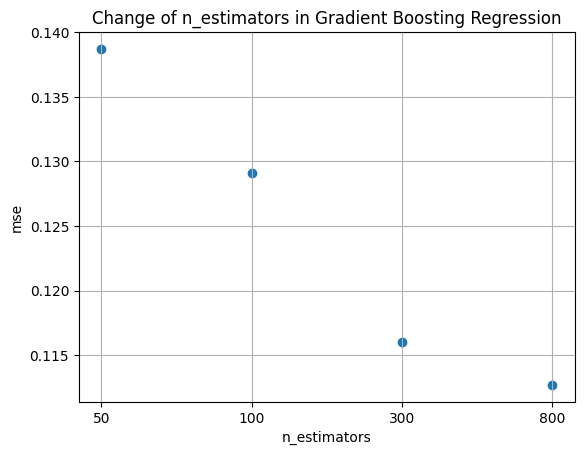

In [ ]:
title = "Change of n_estimators in Gradient Boosting Regression"
xlabel = "n_estimators"
X = []
Y = []
for n_estimators in tqdm([100, 300, 500,700]):
    model = GradientBoostingRegressor(n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

KNN Regression

100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


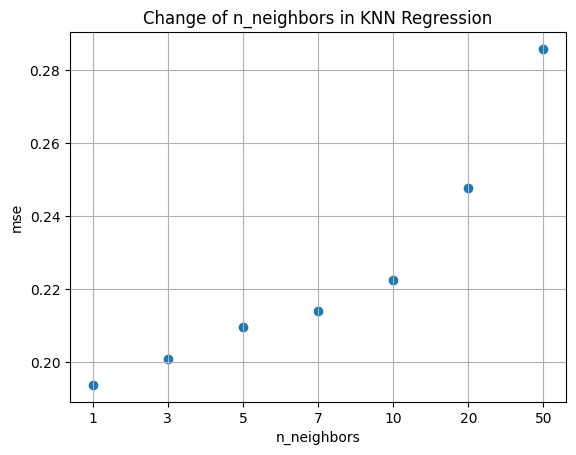

In [88]:
title = "Change of n_neighbors in KNN Regression"
xlabel = "n_neighbors"
X = []
Y = []
for n_neighbors in tqdm([1, 3, 5, 7, 10, 20, 50]):
    model = KNeighborsRegressor(n_neighbors=n_neighbors, metric = 'minkowski')
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_neighbors))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

Random Forest Regression 

100%|██████████| 3/3 [03:35<00:00, 71.72s/it]


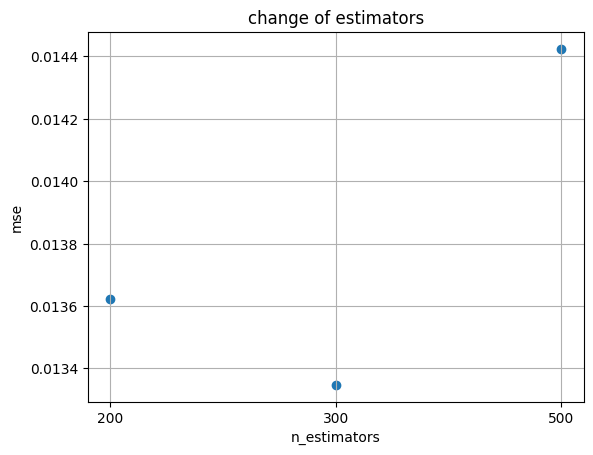

In [ ]:
title = "change of estimators"
xlabel = "n_estimators"
X = []
Y = []
criterion = 'squared_error'
for n_estimators in tqdm([30, 70, 100, 200, 500]):
    model = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators)
    model.fit(normalized_X_train, normalized_y_train)
    normalized_y_pred = model.predict(normalized_X_test)
    normalized_y_pred = model.predict(normalized_X_test)
    y_pred =  y_scaler.inverse_transform(normalized_y_pred.reshape(-1, 1))
    mse = mean_squared_error(y_test, y_pred)
    X.append(str(n_estimators))
    Y.append(mse)
plot(title, xlabel, X, Y)
plt.show()

Results of each model in this dataset after fine-tuned hyper-parameters

In [ ]:
models = {
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting' : GradientBoostingRegressor()
}

def train(X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Training and evaluating {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - Mean Squared Error: {mse}, R-squared: {r2}")